In [1]:
from cowerc_adsorption import PhysicalParams, Simulation, ExperimentalBreakthroughData
import matplotlib.pyplot as plt
import numpy as np

from math import pi
from pathlib import Path

import pandas as pd
from scipy.optimize import Bounds, curve_fit

In [2]:
excel_file = Path("../../.data/Data and Column Properties.xlsx")
sheet_name = "WW All Contaminants 0.18-min"

In [3]:
# Read Emma's excel report
xls_setup = pd.read_excel(excel_file, sheet_name=sheet_name, nrows=18, usecols="A:B", index_col=0)
xls_setup

,Value
Design Parameters,
Column Diameter (cm),0.660000
Column Area (cm^2),0.340000
Particle Size (cm),0.016800
Column Diameter/Particle Size Ratio,39.285714
Reynold&apos;s Number,0.270000
Bed Voidage (ε),0.500000
Hydraulic Loading Rate (cm/s),0.080000
EBCT,0.180000
Flow Rate (mL/s),0.028000


In [4]:
xls_influent = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=11, nrows=4, usecols="D:J")
xls_influent

,Unnamed: 3,PFOA,PFHxA,PFHxS,BEZ,DCF,PFBA
0,Influent 1,185.0,161.50,376,391.00,318.50,160.0
1,Influent 2,161.0,164.00,347,366.50,355.50,165.5
2,Influent 3,189.5,179.50,411,334.00,326.00,174.0
3,Influent AVG,178.5,168.33,378,363.83,333.33,166.5


In [5]:
xls_btc = pd.read_excel(excel_file, sheet_name=sheet_name, header=19, usecols="A:Q")
xls_btc

,Sample ID,Time (min.),Cum. Vol.,Bed Vol Passed (BV),Specific Throughput,PFOA,PFOA C/C0,PFHxA,PFHxA C/C0,PFHxS,PFHxS C/C0,BEZ,BEZ C/C0,DCF,DCF C/C0,PFBA,PFBA C/C0
0,1,30.000000,49.5,170.689655,825.000000,0.50,0.002801,13.70,0.081386,0.00,0.000000,51.25,0.140861,61.30,0.18390,0.00,0.000000
1,2,91.818182,151.5,522.413793,2525.000000,0.00,0.000000,20.50,0.121782,0.00,0.000000,84.00,0.230875,72.45,0.21735,41.35,0.248348
2,3,277.272727,457.5,1577.586207,7625.000000,11.35,0.063585,43.55,0.258713,10.36,0.027407,154.50,0.424645,99.95,0.29985,128.00,0.768769
3,4,775.454545,1279.5,4412.068966,21325.000000,19.15,0.107283,56.10,0.333267,34.05,0.090079,251.50,0.691251,127.50,0.38250,182.00,1.093093
4,5,1274.848485,2103.5,7253.448276,35058.333333,26.80,0.150140,86.75,0.515347,49.80,0.131746,275.00,0.755841,131.15,0.39345,194.50,1.168168
5,6,2325.757576,3837.5,13232.758621,63958.333333,34.25,0.191877,129.00,0.766337,41.75,0.110450,346.00,0.950985,185.50,0.55650,219.50,1.318318
6,7,2882.121212,4755.5,16398.275862,79258.333333,45.60,0.255462,118.50,0.703960,55.05,0.145635,358.50,0.985341,139.00,0.41700,173.00,1.039039
7,9,3403.333333,5615.5,19363.793103,93591.666667,43.75,0.245098,116.00,0.689109,63.00,0.166667,377.00,1.036189,164.00,0.49200,170.50,1.024024
8,10,3924.545455,6475.5,22329.310345,107925.000000,59.25,0.331933,131.00,0.778218,96.60,0.255556,392.50,1.078791,229.00,0.68700,176.50,1.060060
9,12,4966.969697,8195.5,28260.344828,136591.666667,70.05,0.392437,111.00,0.659406,100.05,0.264683,376.00,1.033440,259.00,0.77700,174.50,1.048048


In [6]:
setup = xls_setup.to_dict()["Value"]

In [7]:
porosity = setup["Bed Voidage (ε)"]
lenght = setup["Bed Length (cm)"]

area = 0.25 * pi * setup["Column Diameter (cm)"] ** 2  # cm²
pore_velocity = setup["Flow Rate (mL/min)"] / (area * porosity)  # cm/min

In [8]:
xls_btc

,Sample ID,Time (min.),Cum. Vol.,Bed Vol Passed (BV),Specific Throughput,PFOA,PFOA C/C0,PFHxA,PFHxA C/C0,PFHxS,PFHxS C/C0,BEZ,BEZ C/C0,DCF,DCF C/C0,PFBA,PFBA C/C0
0,1,30.000000,49.5,170.689655,825.000000,0.50,0.002801,13.70,0.081386,0.00,0.000000,51.25,0.140861,61.30,0.18390,0.00,0.000000
1,2,91.818182,151.5,522.413793,2525.000000,0.00,0.000000,20.50,0.121782,0.00,0.000000,84.00,0.230875,72.45,0.21735,41.35,0.248348
2,3,277.272727,457.5,1577.586207,7625.000000,11.35,0.063585,43.55,0.258713,10.36,0.027407,154.50,0.424645,99.95,0.29985,128.00,0.768769
3,4,775.454545,1279.5,4412.068966,21325.000000,19.15,0.107283,56.10,0.333267,34.05,0.090079,251.50,0.691251,127.50,0.38250,182.00,1.093093
4,5,1274.848485,2103.5,7253.448276,35058.333333,26.80,0.150140,86.75,0.515347,49.80,0.131746,275.00,0.755841,131.15,0.39345,194.50,1.168168
5,6,2325.757576,3837.5,13232.758621,63958.333333,34.25,0.191877,129.00,0.766337,41.75,0.110450,346.00,0.950985,185.50,0.55650,219.50,1.318318
6,7,2882.121212,4755.5,16398.275862,79258.333333,45.60,0.255462,118.50,0.703960,55.05,0.145635,358.50,0.985341,139.00,0.41700,173.00,1.039039
7,9,3403.333333,5615.5,19363.793103,93591.666667,43.75,0.245098,116.00,0.689109,63.00,0.166667,377.00,1.036189,164.00,0.49200,170.50,1.024024
8,10,3924.545455,6475.5,22329.310345,107925.000000,59.25,0.331933,131.00,0.778218,96.60,0.255556,392.50,1.078791,229.00,0.68700,176.50,1.060060
9,12,4966.969697,8195.5,28260.344828,136591.666667,70.05,0.392437,111.00,0.659406,100.05,0.264683,376.00,1.033440,259.00,0.77700,174.50,1.048048


In [11]:
experimental_data = ExperimentalBreakthroughData(
    time=np.round((xls_btc["Time (min.)"] * lenght / pore_velocity), 2).to_numpy(),
    conc=xls_btc[["PFBA C/C0", "BEZ C/C0", "PFHxA C/C0", "DCF C/C0", "PFOA C/C0", "PFHxS C/C0"]].to_numpy().T,
)


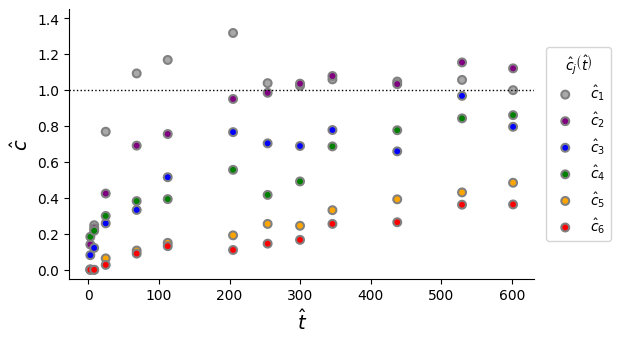

In [12]:
experimental_data.plot_breakthrough()

In [15]:
p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=5000.0,
    k_ads=(50, 50, 50, 50, 50, 50),
    k_des=(1.5, 0.5, 0.15, 0.10, 0.02, 0.01),
)

sim = Simulation(**p.nondim)
sim.end_time = 650
sim.solve()

Finished solve() in 8.3734 secs


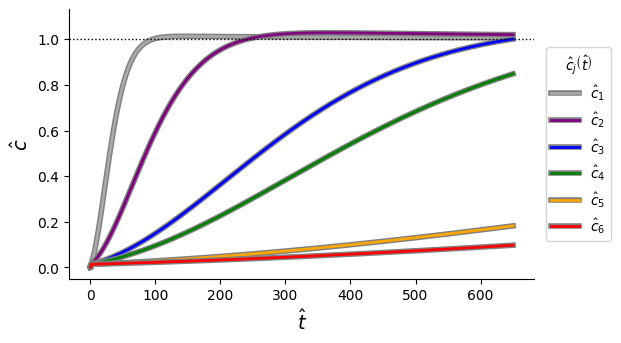

In [16]:
sim.plot_breakthrough()

In [17]:
def f(
    times_to_query,
    sm,
    kads_1,
    kads_2,
    kads_3,
    kads_4,
    kads_5,
    kads_6,
    kdes_1,
    kdes_2,
    kdes_3,
    kdes_4,
    kdes_5,
    kdes_6,
):
    k_ads = (kads_1, kads_2, kads_3, kads_4, kads_5, kads_6)
    k_des = (kdes_1, kdes_2, kdes_3, kdes_4, kdes_5, kdes_6)

    p = PhysicalParams(
        L=lenght,
        v=pore_velocity,
        n=porosity,
        sm=sm,
        k_ads=k_ads,
        k_des=k_des,
    )

    sim = Simulation(**p.nondim)
    sim.end_time = 650
    sim.solve()
    # display(sim.plot_breakthrough())

    # Query the btc from t
    results = sim.btc_df().loc[times_to_query].to_numpy()
    return results.flatten()


In [22]:
p0 = (
    5000,  # sm
    *(50, 50, 50, 50, 50, 50),  # kads
    *(1.5, 0.5, 0.15, 0.10, 0.02, 0.01),  # kdes
)

bounds = Bounds(
    lb=[1, *(0.01, 0.01, 0.01, 0.01, 0.01, 0.01), *(0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001)],
    ub=[10000, *(100, 100, 100, 100, 100, 100), *(10, 10, 10, 10, 10, 10)],
)

fitting_result = curve_fit(
    f,
    xdata=experimental_data.time,
    ydata=experimental_data.conc.T.flatten(),
    p0=p0,
    bounds=bounds,
    method="trf",
    loss="soft_l1",
    full_output=True,
)

Finished solve() in 8.5457 secs
Finished solve() in 8.3221 secs
Finished solve() in 9.0439 secs
Finished solve() in 8.6816 secs
Finished solve() in 8.6963 secs
Finished solve() in 8.6611 secs
Finished solve() in 8.5586 secs
Finished solve() in 8.6480 secs
Finished solve() in 8.4660 secs
Finished solve() in 8.7232 secs
Finished solve() in 8.5000 secs
Finished solve() in 8.5805 secs
Finished solve() in 8.3838 secs
Finished solve() in 8.5548 secs
Finished solve() in 8.3671 secs
Finished solve() in 8.4036 secs
Finished solve() in 8.5955 secs
Finished solve() in 8.4235 secs
Finished solve() in 8.5747 secs
Finished solve() in 8.3654 secs
Finished solve() in 8.5551 secs
Finished solve() in 8.5015 secs
Finished solve() in 8.2914 secs
Finished solve() in 8.5063 secs
Finished solve() in 8.2981 secs
Finished solve() in 8.4774 secs
Finished solve() in 8.3998 secs
Finished solve() in 8.4635 secs
Finished solve() in 8.5756 secs
Finished solve() in 8.5932 secs
Finished solve() in 8.7574 secs
Finished

In [23]:
fitting_result

(array([3.20908461e+03, 4.90204847e+01, 1.93633982e+01, 1.86961836e+01,
        1.73037838e+01, 3.42324156e+01, 3.93637486e+01, 2.95793720e+00,
        2.88454325e-01, 6.91360724e-02, 4.28886565e-02, 3.38554970e-02,
        2.94531282e-02]),
 array([[1.02878084e+07, 2.12989877e+03, 1.85560764e+03, 2.37003289e+03,
         1.32504761e+03, 3.95609615e+03, 4.46774362e+03, 2.96894843e+02,
         1.17888655e+02, 6.54071323e+01, 4.59708873e+01, 4.78739571e+01,
         4.61617791e+01],
        [2.12989877e+03, 3.38577686e+02, 3.91587158e-01, 4.85147052e-01,
         2.68680329e-01, 7.95317220e-01, 8.97764225e-01, 2.16200151e+01,
         2.49696511e-02, 1.36079743e-02, 9.56228680e-03, 9.93123935e-03,
         9.57560874e-03],
        [1.85560764e+03, 3.91587158e-01, 1.08305385e+01, 4.35993657e-01,
         2.43141745e-01, 6.98656555e-01, 7.74357915e-01, 5.23986782e-02,
         2.04655333e-01, 1.19590401e-02, 8.38804584e-03, 8.67727210e-03,
         8.34407440e-03],
        [2.37003289e+03

In [36]:
best_params = fitting_result[0]

p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=best_params[0],
    k_ads=best_params[1:7],
    k_des=best_params[7:],
)

display(p)

PhysicalParams(L=0.85, v=9.645754126781533, n=0.5, sm=np.float64(3209.0846147427933), k_ads=array([49.02048466, 19.3633982 , 18.69618356, 17.30378383, 34.23241556,
       39.36374865]), k_des=array([2.9579372 , 0.28845432, 0.06913607, 0.04288866, 0.0338555 ,
       0.02945313]), C_0=array([1., 1., 1., 1., 1., 1.]))

In [37]:
nsim = Simulation(**p.nondim)
nsim.end_time = 650
nsim.solve()

Finished solve() in 8.3630 secs


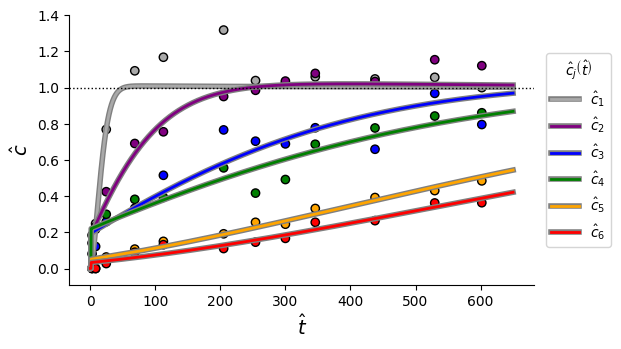

In [45]:
from itertools import cycle
from matplotlib.patheffects import Stroke

colors = cycle(["darkgrey", "purple", "blue", "green", "orange", "red"])

fig = nsim.plot_breakthrough()
ax = fig.axes[0]

for btc, color in zip(experimental_data.conc, colors):
    ax.scatter(
        experimental_data.time,
        btc,
        c=color,
        path_effects=[Stroke(linewidth=1, foreground="#000")],
    )
ax.set_ylim(bottom=-0.09, top=1.4)
display(fig)

**Add bias to the PFBA curve**

In [51]:
# ydata to fit
ydata = experimental_data.conc
ydata

# Biases
sigma = np.ones_like(ydata) * 0.1
sigma[0] = 0.001

In [ ]:
fitting_result_bias = curve_fit(
    f,
    xdata=experimental_data.time,
    ydata=ydata.flatten(),
    sigma=sigma.flatten(),
    p0=best_params,
    bounds=bounds,
    method="trf",
    loss="soft_l1",
    full_output=True,
)

Finished solve() in 8.6202 secs
Finished solve() in 9.3133 secs
Finished solve() in 8.3903 secs
Finished solve() in 8.5856 secs
Finished solve() in 8.6128 secs
Finished solve() in 8.4708 secs
Finished solve() in 8.4246 secs
Finished solve() in 8.9206 secs
Finished solve() in 8.5625 secs
Finished solve() in 8.5099 secs
Finished solve() in 8.7239 secs
Finished solve() in 8.4804 secs
Finished solve() in 8.5236 secs
Finished solve() in 8.5682 secs
Finished solve() in 9.0076 secs
Finished solve() in 8.2185 secs
Finished solve() in 8.1296 secs
Finished solve() in 8.5286 secs
Finished solve() in 8.1590 secs
Finished solve() in 8.2273 secs
Finished solve() in 8.1664 secs
Finished solve() in 8.7287 secs
Finished solve() in 8.2898 secs
Finished solve() in 8.4285 secs
Finished solve() in 8.3316 secs
Finished solve() in 8.1809 secs
Finished solve() in 8.2128 secs
Finished solve() in 8.1788 secs
Finished solve() in 8.7071 secs
Finished solve() in 8.1715 secs
Finished solve() in 8.2151 secs
Finished